<a href="https://colab.research.google.com/github/SeongeunKim-sonja/Keras_example_study_2023/blob/main/Computer_Vision/Image_segmentation_with_a_U_Net_like_architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#U-Net 유사 구조 모델을 이용한 이미지 세그멘테이션 - 뒷부분 추가 중 

*이 문서는 keras 예제를 분석하여 해설을 작성한 것입니다.*

<br>[예제 페이지](https://keras.io/examples/vision/oxford_pets_image_segmentation/)
<br>[U-net 논문 리뷰 참고 블로그1](https://pasus.tistory.com/204)
<br>[U-net 논문 리뷰 참고 블로그2](https://medium.com/@msmapark2/u-net-%EB%85%BC%EB%AC%B8-%EB%A6%AC%EB%B7%B0-u-net-convolutional-networks-for-biomedical-image-segmentation-456d6901b28a)
<br>
<br>
Image Segmentation 이란 이미지의 모든 픽셀이 어떠한 카테고리에 속하는지 분류하는 것을 말한다.<br>
Image Segmentation은 픽셀단위로 분류를 수행하므로, 단일 카테고리를 예측하는 Image classification과는 차별화된다. 


#U-Net

U-Net은 'U-Net: Convolutional Networks for Biomedical Image Segmentation' 이라는 논문에서 제안한 구조.<br>
네트워크 구성의 형태가 'U'형태이다. <br><br>

\[ 간략화한 U-Net 아키텍쳐 \]

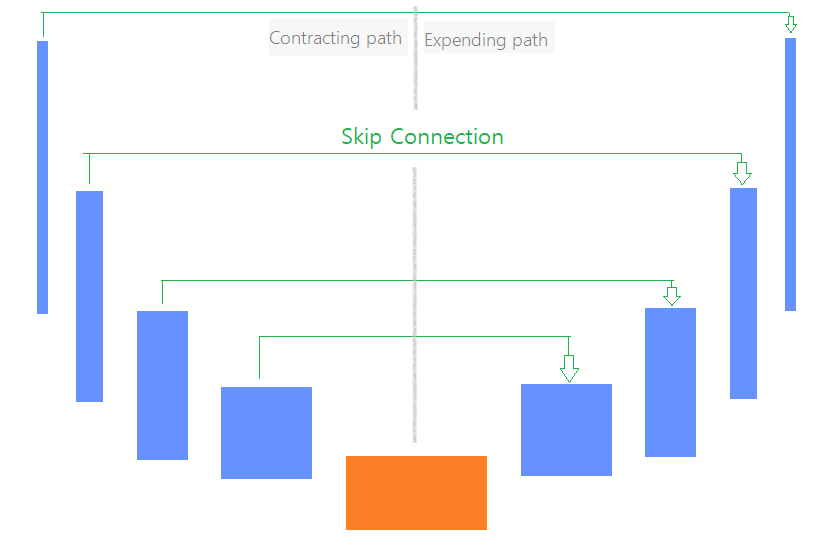

<br>이미지의 정보를 얻기 위한 Contracting Path (FCNs와 같은 VGG 기반 구조)와, 디테일한 Localization을 위한 Expanding Path 가 대칭을 이루고 있다. <br>
Up-sampling (Expanding Path)을 진행할 때에는 인코딩 단계의 각 레이어에서 얻은 특징을 대응하는 디코딩 단계의 레이어에 합쳐서 연산하는데, 이를 Skip connection이라고 한다. 

#Download the data

Oxford-IIIT Pet Dataset 

· 37 종류의 개와 고양이 이미지 데이터셋<br>
· 각각의 카테고리에는 200여장의 이미지가 들어있다.<br>
· 파일명에 품종이 포함되어 있어 분류 문제를 수행할 수 있다.<br>
· 파일당 실제 분할 마스크 이미지가 포함되어 있어 예측한 결과와 비교가 가능하다. <br>

In [7]:
!curl -O https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
!curl -O https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  13.6M      0  0:00:55  0:00:55 --:--:-- 14.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  4731k      0  0:00:03  0:00:03 --:--:-- 4730k


#Prepare paths of input images and target segmentation masks

데이터셋을 정렬하고, 앞의 10개까지 출력하여 나타낸다. 

In [8]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160,160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)
print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path) 
#정렬한 이미지들을 순차적으로 보여줌


Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


#실제 이미지와 마스크 영역 예시

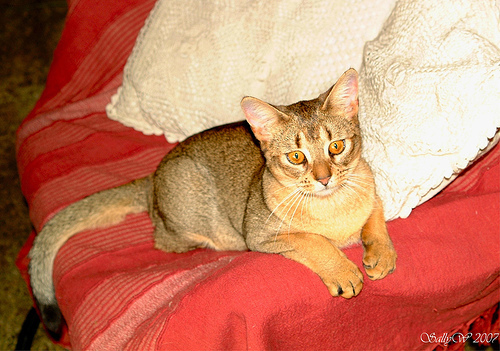

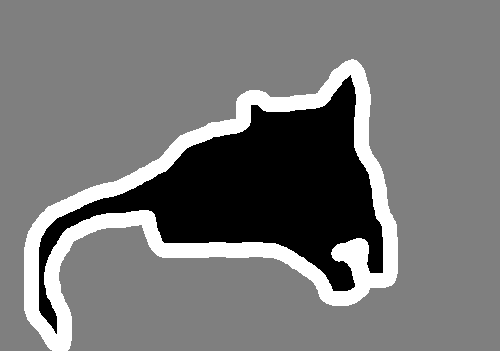

In [10]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps

# Display input image #9
display(Image(filename=input_img_paths[5]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[5]))
display(img)

In [11]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y

#Prepare U-Net Xception-style model

In [12]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###
    #Contracting Path 부분에 해당하는 입력 

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###
    #Expanding Path 에 해당하는 입력

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

#Set aside a validation split

데이터를 training set과 validation set으로 분할한다.

In [13]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

#모델 학습

In [14]:
# target 값이 integer이므로 loss function은 sparse_categorical_crossentropy로 지정한다. 
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
199/199 [==============================] - 51s 186ms/step - loss: 0.9217 - val_loss: 1.9809
Epoch 2/15
199/199 [==============================] - 36s 182ms/step - loss: 0.4991 - val_loss: 1.8648
Epoch 3/15
199/199 [==============================] - 36s 182ms/step - loss: 0.4215 - val_loss: 0.4384
Epoch 4/15
199/199 [==============================] - 36s 181ms/step - loss: 0.3761 - val_loss: 0.4791
Epoch 5/15
199/199 [==============================] - 36s 182ms/step - loss: 0.3431 - val_loss: 0.4060
Epoch 6/15
199/199 [==============================] - 36s 183ms/step - loss: 0.3152 - val_loss: 0.3923
Epoch 7/15
199/199 [==============================] - 36s 182ms/step - loss: 0.2885 - val_loss: 0.3764
Epoch 8/15
199/199 [==============================] - 36s 182ms/step - loss: 0.2678 - val_loss: 0.3643
Epoch 9/15
199/199 [==============================] - 36s 181ms/step - loss: 0.2483 - val_loss: 0.3829
Epoch 10/15
199/199 [==============================] - 36s 181ms/step - l

#예측 시각화

31/31 [==============================] - 5s 156ms/step


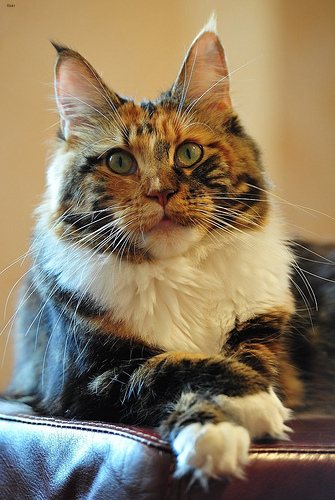

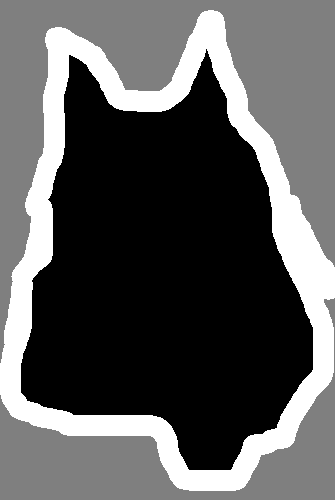

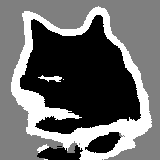

In [16]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 15

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.